# A Novel Task-Duplication Based DAG Scheduling: 
**Algorithm for Heterogeneous Environments by Kun He, Member, IEEE, Xiaozhu Meng*, Zhizhou Pan, Ling Yuan*, Pan Zhou Member, IEEE
[Research Paper Link](https://ieeexplore.ieee.org/abstract/document/8399533)**

Implementation by **Jai Garg (DTU/2K18/MC/044)** and **Jatin Papreja (DTU/2K18/MC/049)**

# Introduction:

In this Project, we have tried to implement the Novel Technique for Task Scheduling on Heterogeneous Systems proposed in the research paper mentioned above. A **Novel Task Duplication based Clustering Algorithm (TDCA)** is proposed to improve the schedule performance by utilizing duplication task more thoroughly. TDCA improves parameter calculation, task duplication, and task merging. It improves the schedule makespan of task duplication-based algorithms for heterogeneous systems for various communication-computing cost ratios.

TDCA contains three main improvements over existing algorithms:
* **New definitions for key parameters such as EST.**
* **Improving the initial clustering.**
* **Consideration of the chain reaction. Keeping alive the prospect of ineffective duplication after some other duplications.**

In [18]:
from copy import deepcopy, copy
from sortedcontainers import SortedSet
from collections import defaultdict
from pandas import *
import pandas as pd
from tabulate import tabulate
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
from IPython.core.display import display, HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

/var/folders/cy/lg_3qnnj0wn4_l3l5nxp8j000000gn/T/ipykernel_22816/1927729062.py:13: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Calculation Of Key Parameters:

In [19]:
def est_max(i, p, Dag_pred, ect, C, fproc):
    mini_list = []
    for j in Dag_pred[i]:
        a = ect[j][fproc[j][0]][0] + C[j][i]
        b = ect[j][p][0]
        mini_list.append(min(a, b))
    return max(mini_list)

In [20]:
def cpred_max(i, Dag_pred, ect, fproc, C):
    c_list = []
    for j in Dag_pred[i]:
        a = ect[j][fproc[j][0]][0]
        if fproc[j][0] != fproc[i][0]:
            a += C[j][i]
        c_list.append([a, j])
    if len(c_list) == 0:
        return -1
    else:
        max_c_list = max(c_list)
        return max_c_list[1]

In [21]:
def level_max(i, T, Dag_succ, level, C):
    l_list = [0]
    a = max(T[i])
    b = 0
    for k in Dag_succ[i]:
        b =  level[k] + C[i][k]
        l_list.append(b)
    l_list_max = max(l_list)
    return (a + l_list_max)

In [22]:
def print_table(n, m, est, ect, fproc, cpred, level):
    ect_new = [[0 for j in range(m)] for i in range(n)]
    for i in range(n):
        for j in range(m):
            ect_new[i][j] = ect[i][j][0]

    fproc_new = [[(fproc[i][j] + 1) for j in range(m)] for i in range(n)]

    cpred_new = [(cpred[i] + 1) for i in range(n)]

    Table = pd.DataFrame(data = {"Earliest Starting Time": est, "Earliest Completion Time": ect_new, "Favourite Processor": fproc_new, "Crititcal Predecessor": cpred_new, "Level": level})
    Table.index = Table.index + 1
    print("="*120)
    print()
    print(tabulate(Table, headers = ["Task Number", "Earliest Starting Time", "Earliest Completion Time", "Favourite Processor", "Critical Predecessor", "Level"], numalign = 'center', stralign = 'center', tablefmt = "pretty"))
    print()

Here, we define a function to get the key parameters before moving on to the four phases to get the final schedule. We calculate the key parameters such as:
* `est`   : Earliest Starting Time
* `ect`   : Earliest Completion Time
* `fproc` : Favourite Processor of Each Task
* `cpred` : Critical Predecessor of Each Task
* `level` : B-Level for Each Task

In [23]:
def Initial_Entry_Table(n, m, Dag_succ, Dag_pred, T, C):
    est = [[0 for j in range(m)] for i in range(n)]
    
    ect = [[[0, j] for j in range(m)] for i in range(n)]
    for j in range(m):
        ect[0][j][0] = T[0][j]
    
    sort_ect = sorted(ect[0])
    fproc = [[0 for j in range(m)] for i in range(n)]
    for j in range(m):
        fproc[0][j] = sort_ect[j][1]
        
    for i in range(1, n):
        for j in range(m):
            est[i][j] = est_max(i, j, Dag_pred, ect, C, fproc)
            ect[i][j][0] = est[i][j] + T[i][j]
        sort_ect = sorted(ect[i])
        for j in range(m):
            fproc[i][j] = sort_ect[j][1]
    
    cpred = [0 for i in range(n)]
    for i in range(n):
        cpred[i] = cpred_max(i, Dag_pred, ect, fproc, C)
    
    level = [0 for i in range(n)]
    for i in range(n-1, -1, -1):
        level[i] = level_max(i, T, Dag_succ, level, C)

    print_table(n, m, est, ect, fproc, cpred, level)
    return est, ect, fproc, cpred, level

Next, we define a function to draw the DAG for the given Task Hierarchy.

In [24]:
def draw_graph(n, G, Dag_succ):
    weight = nx.get_edge_attributes(G, 'weight')
    visited = [0]*n
    level = defaultdict(list)
    pos = {}

    def rec_dfs(visited, Dag_succ, node, l):
        if visited[node] == 1:
            return
        visited[node] = 1
        level[l].append(node)
        for neighbour in Dag_succ[node]:
            rec_dfs(visited, Dag_succ, neighbour, l+1)

    rec_dfs(visited, Dag_succ, 0, 0)
    
    for elem in level:
        level[elem].sort()
    
    for elem in level:
        y = -elem
        d = 3
        length = len(level[elem])

        if (length)%2 == 0:
            x = 0
            for j in range((length//2), length, 1):
                x = x + d
                pos[level[elem][j] + 1] = (x, y)

            x = 0
            for j in range(((length//2)-1), -1, -1):
                x = x - d
                pos[level[elem][j] + 1] = (x, y)

        else:
            x = 0
            for j in range((length//2), length, 1):
                pos[level[elem][j] + 1] = (x, y)
                x = x + d

            x = 0
            for j in range(((length//2)-1), -1, -1):
                x = x - d
                pos[level[elem][j] + 1] = (x, y)

    plt.figure(figsize = (10, 12))
    nx.draw_networkx(G, pos, edge_color='darkblue', with_labels = True, node_color = 'cyan', font_size = 15, arrowsize = 15, node_size = (2000), node_shape = 'o')
    pl = nx.draw_networkx_edge_labels(G, pos, edge_labels = weight, rotate = False, font_size = 14, label_pos = 0.65)

Now, We define a function to calculate the makespan which can be used as a metric for performance improvement given by the TDCA algorithm.

In [25]:
def calc_makespan(n, m, T, C, Dag_succ, Dag_pred, cluster_mat):
    makespan = [[0 for j in range(m)] for i in range(n)]
    
    for p in range(m):
        if 0 in cluster_mat[p]:
            makespan[0][p] = T[0][p]
        
    for i in range(1, n):
        for p in range(m):
            if i not in cluster_mat[p]:
                continue
            cand_list = []
            for j in Dag_pred[i]:
                if j in cluster_mat[p]:
                    a = makespan[j][p]
                    cand_list.append(a)
                    continue
                else:
                    for k in range(m):
                        if j in cluster_mat[k]:
                            a = makespan[j][k] + C[j][i]
                            cand_list.append(a)
            makespan[i][p] = max(cand_list) + T[i][p]
    
    return max(makespan[n-1])

Next up, we define the Data Structures that will be used in the four phases that are essential for the implementation of the algorithm.

In [26]:
def initialization_phase(n, m, level):
    task_arr = []
    for i in range(n):
        task_arr.append([level[i], i])
    task_arr = sorted(task_arr)
    task_assign = [0]*n
    task = []
    for i in range(n):
        task.append(task_arr[i][1])
    occ_proc = [0]*m
    cluster_mat = [SortedSet() for j in range(m)]
    return task, task_assign, occ_proc, cluster_mat

Finally, we start with the four phases which will help us to achieve task scheduling in an optimized and effective manner.
The Four Phases are:
* **Initial Clustering Phase**: TDCA starts to construct the initial clusters. Iteratively, TDCA chooses several tasks and assigns them to the best unoccupied processor.
* **Task Duplication Phase**: In this phase, TDCA duplicates tasks on different processor in order to improve the makespan of the scheduling achieved in the clustering phase.
* **Task Merging Phase**: In the third phase, TDCA tries to merge clusters to see if the makespan could be further reduced.
* **Task Insertion Phase**: This is the last phase, in which a task is checked if it can be inserted in an idle time interval so that its successor can start early. 

# Initial Clustering Phase:

In [27]:
#INITIAL CLUSTERING PHASE - 1
def initial_clustering_phase(n, m, T, C, task, task_assign, occ_proc, cluster_mat, est, ect, fproc, cpred, level, Dag_succ, Dag_pred, entry_node, exit_node):
    for i in task:
        if task_assign[i] == 1:
            continue
        curProc = -1
        for j in range(m):
            if occ_proc[fproc[i][j]] == 0:
                curProc = fproc[i][j]
                cluster_mat[curProc].add(i)
                task_assign[i] = 1
                break
        if curProc == -1:
            cluster_mat[fproc[i][0]].add(i)
            continue
        
        while i != entry_node: #entry-node
            j = cpred[i]
            a = ect[j][curProc][0]
            b = ect[j][fproc[j][0]][0] + C[j][i]
            if (len(Dag_pred[i]) > 1) and ((task_assign[j] == 1) or (a > b)):
                mink_list = []
                for z in Dag_pred[i]:
                    a1 = ect[z][curProc][0]
                    b1 = ect[z][fproc[z][0]][0] + C[z][i]
                    if (task_assign[z] == 0) and (a1 <= b1):
                        new_ect = ect[z][curProc][0]
                        mink_list.append([new_ect, z])
                if len(mink_list) == 0:
                    break
                new_pred = min(mink_list)
                j = new_pred[1]
            cluster_mat[curProc].add(j)
            task_assign[j] = 1
            i = j
        occ_proc[curProc] = 1
    return n, m, T, C, task, task_assign, occ_proc, cluster_mat, est, ect, fproc, cpred, level, Dag_succ, Dag_pred, entry_node, exit_node

# Task Duplication Phase:

In [28]:
#TASK DUPLICATION PHASE - 2
def task_duplication_phase(K, n, m, T, C, task, task_assign, occ_proc, cluster_mat, est, ect, fproc, cpred, level, Dag_succ, Dag_pred, entry_node, exit_node):
    for _ in range(K):
        for p in range(m):
            Xp = list(cluster_mat[p])
            for i in range(len(Xp)-1, 0, -1):
                if Xp[i-1] != cpred[Xp[i]]:
                    next_proc = -1
                    if 0 in occ_proc:
                        for j in fproc[Xp[i-1]]:
                            if occ_proc[j] == 0:
                                next_proc = j
                                break
                    else:
                        next_proc = fproc[Xp[i-1]][0]
                    new_cluster_mat = deepcopy(cluster_mat)
                    for j in Xp[0:i]:
                        new_cluster_mat[p].discard(j)
                        new_cluster_mat[next_proc].add(j)
                    z = Xp[i]
                    while z != entry_node: #entry-node
                        z_pred = cpred[z]
                        new_cluster_mat[p].add(z_pred)
                        z = z_pred
                    if calc_makespan(n, m, T, C, Dag_succ, Dag_pred, new_cluster_mat) <= calc_makespan(n, m, T, C, Dag_succ, Dag_pred, cluster_mat):
                        cluster_mat = deepcopy(new_cluster_mat)
                        occ_proc[next_proc] = 1
            Xp = list(cluster_mat[p])
            if len(Xp) > 0 and Xp[0] != entry_node: # entry-node
                new_cluster_mat = deepcopy(cluster_mat)
                z = Xp[0]
                while z != entry_node: #entry-node
                    z_pred = cpred[z]
                    new_cluster_mat[p].add(z_pred)
                    z = z_pred
                if calc_makespan(n, m, T, C, Dag_succ, Dag_pred, new_cluster_mat) <= calc_makespan(n, m, T, C, Dag_succ, Dag_pred, cluster_mat):
                    cluster_mat = deepcopy(new_cluster_mat)
    return K, n, m, T, C, task, task_assign, occ_proc, cluster_mat, est, ect, fproc, cpred, level, Dag_succ, Dag_pred, entry_node, exit_node

# Task Merging Phase:

In [29]:
def task_merging_phase(K, n, m, T, C, task, task_assign, occ_proc, 
                       cluster_mat, est, ect, fproc, cpred, level, 
                       Dag_succ, Dag_pred, entry_node, exit_node):
#TASK MERGING PHASE - 3
    for _ in range(K):
        span_list = []
        for p in range(m):
            Xp = list(cluster_mat[p])
            if len(Xp) > 0:
                new_cluster_mat = deepcopy(cluster_mat)
                x = Xp[len(Xp) - 1]
                next_proc = fproc[x][0]
                for j in Xp:
                    new_cluster_mat[p].discard(j)
                    new_cluster_mat[next_proc].add(j)
                span_list.append([calc_makespan(n, m, T, C, Dag_succ, Dag_pred, 
                                                new_cluster_mat), new_cluster_mat])
        min_makespan = min(span_list)
        if min_makespan[0] < calc_makespan(n, m, T, C, Dag_succ, 
                                           Dag_pred, cluster_mat):
            cluster_mat = deepcopy(min_makespan[1])
    return (K, n, m, T, C, task, task_assign, occ_proc, 
            cluster_mat, est, ect, fproc, cpred, level, 
            Dag_succ, Dag_pred, entry_node, exit_node)

# Task Insertion Phase:

In [30]:
#TASK INSERTION PHASE - 4
def task_insertion_phase(K, n, m, T, C, task, task_assign, occ_proc, cluster_mat, est, ect, fproc, cpred, level, Dag_succ, Dag_pred, entry_node, exit_node):
    span_list = []
    for i in range(1, n):
        for j in Dag_succ[i]:
            for p in range(m):
                Xp = list(cluster_mat[p])
                if (j in Xp) and (i not in Xp):
                    new_cluster_mat = deepcopy(cluster_mat)
                    new_cluster_mat[p].add(i)
                    span_list.append([calc_makespan(n, m, T, C, Dag_succ, Dag_pred, new_cluster_mat), new_cluster_mat, i])
    min_makespan = min(span_list)
    if min_makespan[0] < calc_makespan(n, m, T, C, Dag_succ, Dag_pred, cluster_mat):
        cluster_mat = deepcopy(min_makespan[1])
        x = min_makespan[2]
        if x != exit_node: #exit-node
            for p in range(m):
                if x in cluster_mat[p]:
                    flag = 0
                    for j in Dag_succ[x]:
                        if j in cluster_mat[p]:
                            flag = 1
                            break
                    if flag == 0:
                        new_cluster_mat = deepcopy(cluster_mat)
                        new_cluster_mat[p].discard(x)
                        if calc_makespan(n, m, T, C, Dag_succ, Dag_pred, new_cluster_mat) < calc_makespan(n, m, T, C, Dag_succ, Dag_pred, cluster_mat):
                            cluster_mat = deepcopy(new_cluster_mat)
    return K, n, m, T, C, task, task_assign, occ_proc, cluster_mat, est, ect, fproc, cpred, level, Dag_succ, Dag_pred, entry_node, exit_node

In [31]:
def schedule(n, m, cluster_mat):
    for i in range(m):
        final_list = list(cluster_mat[i])
        final_list = np.array(final_list)
        final_list = final_list + 1
        proc_no = "P" + str(i+1)
        print(proc_no,"->", *final_list)

In [32]:
def print_all_graph():
    plt.style.use("seaborn-darkgrid")
    plt.figure(figsize = (15, 8))
    x = np.arange(30, 105, 5)
    y1 = [1050, 1125, 1080, 1175, 1280, 1300, 1400, 1325, 1410, 1425, 1390, 1450, 1560, 1595, 1600]
    y2 = [1325, 1390, 1425, 1475, 1500, 1550, 1620, 1560, 1650, 1655, 1620, 1620, 1800, 1815, 1800]
    y3 = [1400, 1475, 1480, 1525, 1590, 1610, 1760, 1620, 1750, 1775, 1700, 1760, 1900, 1930, 1830]
    y4 = [1375, 1500, 1580, 1600, 1820, 1800, 1925, 1825, 2025, 2000, 1980, 2010, 2275, 2375, 2230]
    plt.plot(x, y1, marker = 'o', markeredgecolor = 'black', markersize = 8, label = "TDCA", color = 'cyan')
    plt.plot(x, y2, marker = '^', markeredgecolor = 'black', markersize = 8, label = "DCPD", color = 'red')
    plt.plot(x, y3, marker = '*', markeredgecolor = 'black', markersize = 8, label = "HEFT", color = 'green')
    plt.plot(x, y4, marker = 's', markeredgecolor = 'black', markersize = 8, label = "TANH", color = 'blue')
    plt.xlim(30,100) 
    plt.ylim(1000, 2400)
    plt.title("Mean Makespan v/s Number of Nodes", loc = 'center', size = 20)
    plt.xlabel("Number of Nodes", size = 20)
    plt.ylabel("Mean Makespan", size = 20)
    plt.yticks(fontsize = 16)
    plt.xticks(fontsize = 16)
    plt.legend(fontsize = 16, frameon = True, fancybox = True, shadow = True, facecolor = 'white')
    plt.show()
    
    plt.figure(figsize = (15, 8))
    x = np.array([0, 0.3, 0.6, 0.8, 1, 1.2, 1.5, 1.8, 2, 2.4, 3, 5, 7, 10, 15])
    y1 = [400, 550, 800, 900, 950, 975, 1025, 1100, 1300, 1500, 1800, 2400, 3200, 3800, 5500]
    y2 = [400, 550, 825, 925, 975, 1050, 1100, 1250, 1500, 1850, 2010, 2750, 4000, 4400, 5100]
    y3 = [400, 550, 825, 925, 975, 1050, 1100, 1400, 1600, 1900, 2100, 3000, 4200, 4800, 5750]
    y4 = [900, 1000, 1050, 1200, 1250, 1400, 1500, 1650, 1800, 2000, 2400, 3400, 4300, 5200, 8000]
    plt.plot(x, y1, marker = 'o', markeredgecolor = 'black', markersize = 8, label = "TDCA", color = 'cyan')
    plt.plot(x, y2, marker = '^', markeredgecolor = 'black', markersize = 8, label = "DCPD", color = 'red')
    plt.plot(x, y3, marker = '*', markeredgecolor = 'black', markersize = 8, label = "HEFT", color = 'green')
    plt.plot(x, y4, marker = 's', markeredgecolor = 'black', markersize = 8, label = "TANH", color = 'blue')
    plt.xlim(0,15) 
    plt.ylim(0, 9000)
    plt.title("Mean Makespan v/s CCR", loc = 'center', size = 20)
    plt.xlabel("CCR", size = 20)
    plt.ylabel("Mean Makespan", size = 20)
    plt.yticks(fontsize = 16)
    plt.xticks(fontsize = 16)
    plt.legend(fontsize = 16, frameon = True, fancybox = True, shadow = True, facecolor = 'white')
    plt.show()
    
    plt.figure(figsize=(15,8))
    x = np.arange(0,1.5,0.1)
    y1 = [1500,1580,1560,1490,1450,1380,1220,1240,1210,1170,1160,1020,1150,1005,1050]
    y2 = [1700,1800,1710,1690,1680,1520,1500,1520,1490,1400,1420,1290,1395,1310,1410]
    y3 = [1850,1890,1810,1793,1730,1650,1550,1600,1580,1440,1500,1390,1540,1330,1490]
    y4 = [1710,1810,1720,1705,1785,1630,1520,1900,1820,1780,1690,1770,1930,1780,2010]
    plt.plot(x,y1,marker='o',color='cyan',markeredgecolor='black',markersize=8,label = "TDCA")
    plt.plot(x,y2,marker='^',color='red',markeredgecolor='black',markersize=8,label = "DCPD")
    plt.plot(x,y3,marker='*',color='green',markeredgecolor='black',markersize=8,label = "HEFT")
    plt.plot(x,y4,marker='s',color='blue',markeredgecolor='black',markersize=8,label = "TANH")
    plt.xlim(0,1.4) 
    plt.ylim(1000, 2400)
    plt.title("Mean Makespan v/s Heterogeneity", loc = 'center', size = 20)
    plt.xlabel("Heterogeneity", size = 20)
    plt.ylabel("Mean Makespan", size = 20)
    plt.yticks(fontsize = 16)
    plt.xticks(fontsize = 16)
    plt.legend(fontsize = 16, frameon = True, fancybox = True, shadow = True, facecolor = 'white', loc = 'upper left')
    plt.show()
    
    plt.figure(figsize=(15,8))
    x = np.arange(3,18,1)
    y1 = [750,850,990,1100,1250,1480,1520,1600,1800,1900,1990,2150,2050,2300,2350]
    y2 = [900,1000,1150,1300,1500,1700,1950,2010,2250,2400,2410,2750,2600,2900,2950]
    y3 = [910,1050,1220,1310,1550,1710,1990,2050,2300,2500,2510,2780,2610,2910,3100]
    y4 = [1100,1250,1300,1400,1700,2100,2100,2350,2500,2495,2700,2900,2600,2920,3200]
    plt.plot(x,y1,marker='o',color='cyan',markeredgecolor='black',markersize=8,label = "TDCA")
    plt.plot(x,y2,marker='^',color='red',markeredgecolor='black',markersize=8,label = "DCPD")
    plt.plot(x,y3,marker='*',color='green',markeredgecolor='black',markersize=8,label = "HEFT")
    plt.plot(x,y4,marker='s',color='blue',markeredgecolor='black',markersize=8,label = "TANH")
    plt.xlim(3,17) 
    plt.ylim(500, 3500)
    plt.title("Mean Makespan v/s Number of Layers", loc = 'center', size = 20)
    plt.xlabel("Number of Layers", size = 20)
    plt.ylabel("Mean Makespan", size = 20)
    plt.yticks(fontsize = 16)
    plt.xticks(fontsize = 16)
    plt.legend(fontsize = 16, frameon = True, fancybox = True, shadow = True, facecolor = 'white',loc='upper left')
    plt.show()

Finally, we combine all the above functions in the `main` function to get the final schedule.

In [33]:
#DAG Formation - Input Function
def main():
    n = int(input("Enter the Number of Processes:"))
    m = int(input("Enter the Number of Processors:"))
    E = int(input("Enter the Number of Edges in Directed Acyclic Graph (DAG):"))
    entry_node = 0
    exit_node = n-1
    K = 4
    
    print("Enter the Edges of DAG along with edge weight i.e. communication time. Format: Predecessor, Successor, Weight")
    Dag_succ = defaultdict(list)
    Dag_pred = defaultdict(list)
    C = [[0 for j in range(n)] for i in range(n)]
    G = nx.DiGraph()
    map(G.add_node, range(1, n+1))
    input_list = list(map(int, input().split()))
    for i in range(0, len(input_list), 3):
        u = input_list[i]
        v = input_list[i+1]
        w = input_list[i+2]
        C[u][v] = w
        Dag_succ[u].append(v)
        Dag_pred[v].append(u)
        G.add_edge(u+1, v+1, weight = w)
    Dag_succ[exit_node] = []
    Dag_pred[entry_node] = []
    
    print("Enter the Computation Matrix i.e. the time taken to compute each task on each processor:")
    T = []
    i_list= list(map(int, input().split()))
    for i in range(0, len(i_list), m):
        s = []
        for j in range(m):
            s.append(i_list[i+j])
        T.append(s)
    print()
    print('\033[1m')
    print("DAG Successor List:")
    print('\033[0m')
    for i in range(n):
        print(i, ":", Dag_succ[i])
    print()
    print('\033[1m')
    print("DAG Predecessor List:")
    print('\033[0m')
    for i in range(n):
        print(i, ":", Dag_pred[i])
    print()
    
    print('\033[1m')
    print("Computation Matrix:")
    print('\033[0m')
    print(tabulate(DataFrame(T, index = None), numalign = 'center', stralign = 'center', tablefmt = "grid", showindex = False))
    print()
    
    print('\033[1m')
    print("Communication Matrix:")
    print('\033[0m')
    print(tabulate(DataFrame(C, index = None), numalign = 'center', stralign = 'center', tablefmt = "grid", showindex = False))
    print()
    
    est, ect, fproc, cpred, level = Initial_Entry_Table(n, m, Dag_succ, Dag_pred, T, C)
    
    task, task_assign, occ_proc, cluster_mat = initialization_phase(n, m, level)
    
    #print(task, task_assign, occ_proc, cluster_mat)
    
    n, m, T, C, task, task_assign, occ_proc, cluster_mat, est, ect, fproc, cpred, level, Dag_succ, Dag_pred, entry_node, exit_node = initial_clustering_phase(n, m, T, C, task, task_assign, occ_proc, cluster_mat, est, ect, fproc, cpred, level, Dag_succ, Dag_pred, entry_node, exit_node)
    print()
    print('\033[1m')
    print("Schedule after Initial Clustering Phase")
    print('\033[0m')
    schedule(n, m, cluster_mat)
    print("Makespan :", calc_makespan(n, m, T, C, Dag_succ, Dag_pred, cluster_mat))
    print()
    
    K, n, m, T, C, task, task_assign, occ_proc, cluster_mat, est, ect, fproc, cpred, level, Dag_succ, Dag_pred, entry_node, exit_node = task_duplication_phase(K, n, m, T, C, task, task_assign, occ_proc, cluster_mat, est, ect, fproc, cpred, level, Dag_succ, Dag_pred, entry_node, exit_node)
    print('\033[1m')
    print("Schedule after Task Duplication Phase")
    print('\033[0m')
    schedule(n, m, cluster_mat)
    print("Makespan :", calc_makespan(n, m, T, C, Dag_succ, Dag_pred, cluster_mat))
    print()
    
    K, n, m, T, C, task, task_assign, occ_proc, cluster_mat, est, ect, fproc, cpred, level, Dag_succ, Dag_pred, entry_node, exit_node = task_merging_phase(K, n, m, T, C, task, task_assign, occ_proc, cluster_mat, est, ect, fproc, cpred, level, Dag_succ, Dag_pred, entry_node, exit_node)
    print('\033[1m')
    print("Schedule after Task Merging Phase")
    print('\033[0m')
    schedule(n, m, cluster_mat)
    print("Makespan :", calc_makespan(n, m, T, C, Dag_succ, Dag_pred, cluster_mat))
    print()
    
    K, n, m, T, C, task, task_assign, occ_proc, cluster_mat, est, ect, fproc, cpred, level, Dag_succ, Dag_pred, entry_node, exit_node = task_insertion_phase(K, n, m, T, C, task, task_assign, occ_proc, cluster_mat, est, ect, fproc, cpred, level, Dag_succ, Dag_pred, entry_node, exit_node)
    print('\033[1m')
    print("Schedule after Task Insertion Phase")
    print('\033[0m')
    schedule(n, m, cluster_mat)
    print("Makespan :", calc_makespan(n, m, T, C, Dag_succ, Dag_pred, cluster_mat))
    print()
    
    print('\033[1m')
    print("Final Schedule:")
    print('\033[0m')
    schedule(n, m, cluster_mat)
    print("Makespan :", calc_makespan(n, m, T, C, Dag_succ, Dag_pred, cluster_mat))
    print()
    
    print('\033[1m')
    print("The DAG of given input is:")
    print('\033[0m')
    draw_graph(n, G, Dag_succ)

    
    print_all_graph()

**Input Guide:**
* Enter the Number of Processes: 10
* Enter the Number of Processors: 5
* Enter the Number of Edges in Directed Acyclic Graph (DAG): 13
* Enter the Edges of DAG:
    * `0 1 6` 
    * `0 2 6`
    * `0 3 10`
    * `1 4 8`
    * `2 4 9`
    * `2 5 4`
    * `2 6 8`
    * `3 6 5`
    * `4 7 7`
    * `5 7 8`
    * `6 8 7`
    * `7 9 10`
    * `8 9 5`
    * Input : 0 1 6 0 2 6 0 3 10 1 4 8 2 4 9 2 5 4 2 6 8 3 6 5 4 7 7 5 7 8 6 8 7 7 9 10 8 9 5
* Enter the Computation Matrix i.e. the time taken to compute each task on each processor:
    * `3 6 5 5 4`
    * `6 3 5 7 3`
    * `6 5 7 7 6`
    * `5 6 4 4 4`
    * `7 2 4 2 2`
    * `6 7 4 6 5`
    * `6 4 5 4 6`
    * `6 6 5 5 6`
    * `4 5 3 2 3`
    * `3 1 7 1 2`
    * Input : 3 6 5 5 4 6 3 5 7 3 6 5 7 7 6 5 6 4 4 4 7 2 4 2 2 6 7 4 6 5 6 4 5 4 6 6 6 5 5 6 4 5 3 2 3 3 1 7 1 2
    
    
* Input 1: 0 1 6 0 2 6 0 3 10 1 4 8 2 4 9 2 5 4 2 6 8 3 6 5 4 7 7 5 7 8 6 8 7 7 9 10 8 9 5


* Input 2: 3 6 5 5 4 6 3 5 7 3 6 5 7 7 6 5 6 4 4 4 7 2 4 2 2 6 7 4 6 5 6 4 5 4 6 6 6 5 5 6 4 5 3 2 3 3 1 7 1 2


* **Alternative Input: (Not Taken From Research Paper)**
    * n = 10
    * m = 3
    * no. of edges = 15
    * DAG Input: 0 1 18 0 2 12 0 3 9 0 4 11 0 5 14 1 7 19 1 8 16 2 6 23 3 7 27 3 8 23 4 8 13 5 7 15 6 9 17 7 9 11 8 9 13
    * Computation Matrix: 14 16 9 13 19 18 11 13 19 13 8 7 12 13 10 13 16 9 7 15 11 5 11 14 18 12 20 21 7 16
    * The results of other Scheduling Algorithms can be found [here](https://www.hindawi.com/journals/sp/2016/3676149/tab2/) for comparison purposes.
    

# Output and Analysis:
Now, we finally call the main function along with the input required. We will see all the key parameters listed in a Tabular Form below. Finally, we will see the schedule along with the makespan given by TDCA after every phase. The DAG is drawn to understand the Task Hierarchy in a visual manner. Finally, the performance analysis of the proposed algorithm is represented by comparing it to other existing algorithm in a graphical manner. 

Enter the Number of Processes:10
Enter the Number of Processors:5
Enter the Number of Edges in Directed Acyclic Graph (DAG):13
Enter the Edges of DAG along with edge weight i.e. communication time. Format: Predecessor, Successor, Weight
0 1 6 0 2 6 0 3 10 1 4 8 2 4 9 2 5 4 2 6 8 3 6 5 4 7 7 5 7 8 6 8 7 7 9 10 8 9 5
Enter the Computation Matrix i.e. the time taken to compute each task on each processor:
3 6 5 5 4 6 3 5 7 3 6 5 7 7 6 5 6 4 4 4 7 2 4 2 2 6 7 4 6 5 6 4 5 4 6 6 6 5 5 6 4 5 3 2 3 3 1 7 1 2


DAG Successor List:

0 : [1, 2, 3]
1 : [4]
2 : [4, 5, 6]
3 : [6]
4 : [7]
5 : [7]
6 : [8]
7 : [9]
8 : [9]
9 : []


DAG Predecessor List:

0 : []
1 : [0]
2 : [0]
3 : [0]
4 : [1, 2]
5 : [2]
6 : [2, 3]
7 : [4, 5]
8 : [6]
9 : [7, 8]


Computation Matrix:

+---+---+---+---+---+
| 3 | 6 | 5 | 5 | 4 |
+---+---+---+---+---+
| 6 | 3 | 5 | 7 | 3 |
+---+---+---+---+---+
| 6 | 5 | 7 | 7 | 6 |
+---+---+---+---+---+
| 5 | 6 | 4 | 4 | 4 |
+---+---+---+---+---+
| 7 | 2 | 4 | 2 | 2 |
+---+---+---+---+---+

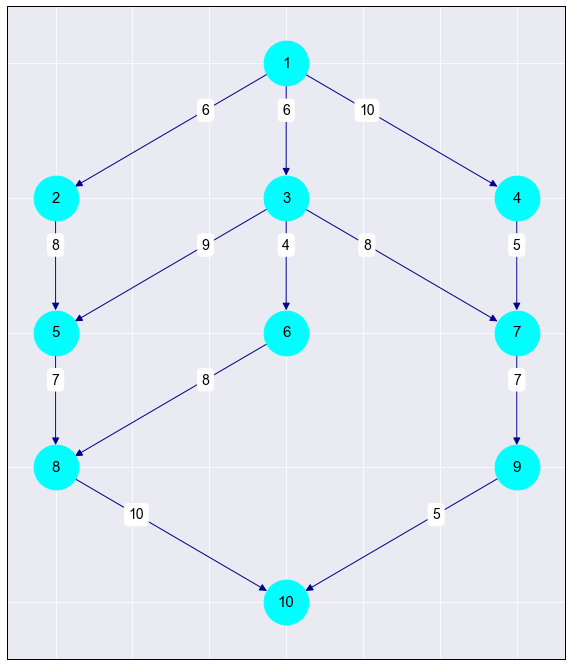

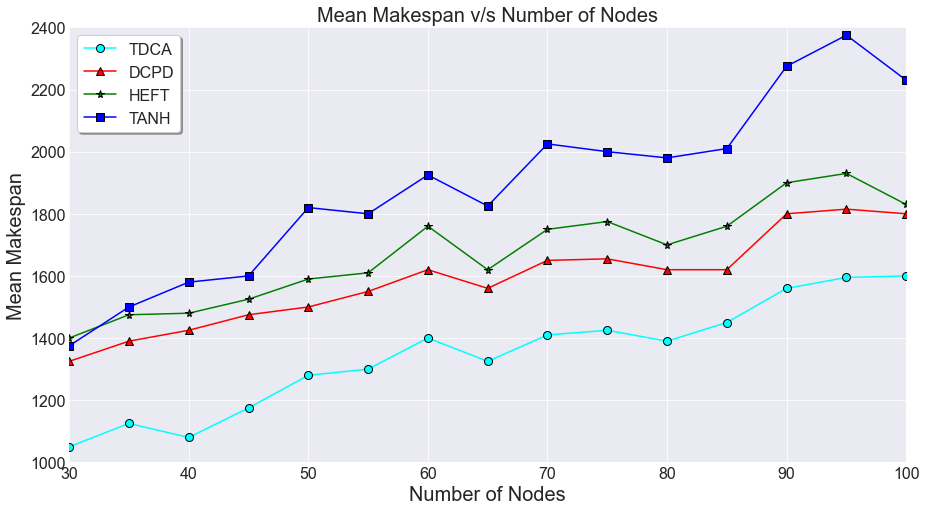

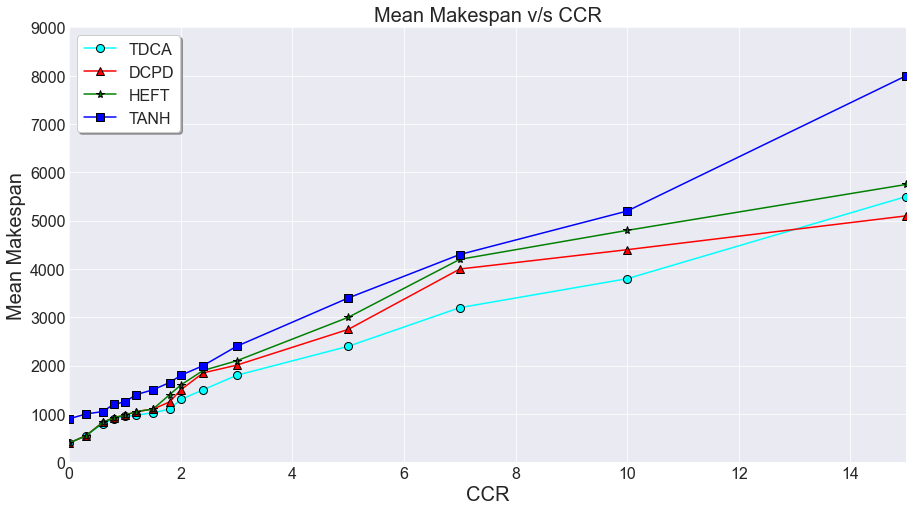

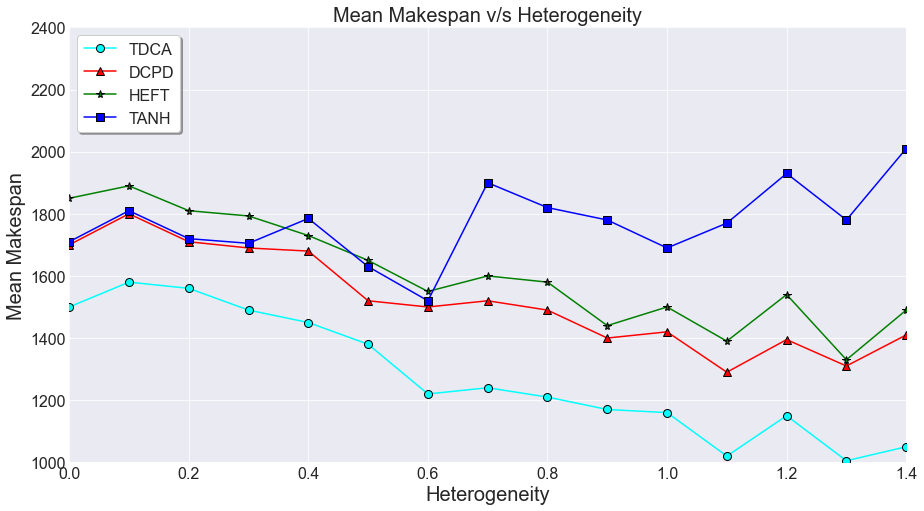

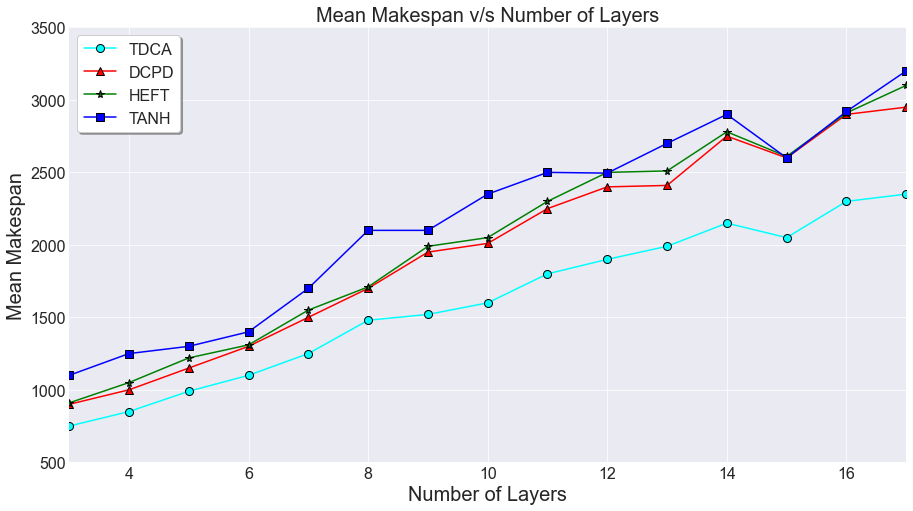

In [34]:
main()